# Chinook Records Store Database - Answering Business Questions using SQL

In this project we will be working with a modified version of a database called Chinook. The Chinook database contains information about a fictional digital music shop - a smaller version of iTunes.

The database contains information about the artists, songs, and albums from the music shop, as well as information on the shop's employees, customers, and their purchases. This information is contained in eleven tables. Here is a schema diagram for the Chinook database:

![](/images/chinook.png)

In [1]:
%%capture
%load_ext sql
%sql sqlite:///chinook.db
# Connect to database    

'Connected: None@chinook.db'

In [2]:
# Import python libraries
import sqlite3 
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.style as style
style.use('fivethirtyeight') #set fivethirtyeight on plots
%matplotlib inline

In [3]:
%%sql
--#First look at whole databse
SELECT
    name,
    type
FROM sqlite_master
WHERE type IN ("table","view");

Done.


name,type
album,table
artist,table
customer,table
employee,table
genre,table
invoice,table
invoice_line,table
media_type,table
playlist,table
playlist_track,table


## Selecting Albums to Purchase

First, we'll investigate total sales for each music category. Our aim is to find the most popular categories.

In [4]:
%%sql
WITH tracks_solds AS
     (
     SELECT
          t.track_id,
           t.genre_id,
           il.invoice_id,
           i.customer_id,
           c.country,
           SUM(il.quantity) solds
     FROM track t
     INNER JOIN invoice_line il ON il.track_id = t.track_id
     INNER JOIN invoice i ON i.invoice_id = il.invoice_id
     INNER JOIN customer c ON c.customer_id = i.customer_id
     WHERE c.country = 'USA'
    GROUP BY 2
     ),
    genres AS
    (
    SELECT 
         g.genre_id,
         g.name,
         ts.solds
    FROM genre g
    INNER JOIN tracks_solds ts ON ts.genre_id = g.genre_id    
    )
SELECT
    genres.name genre,
    genres.solds,
    ROUND(CAST(genres.solds AS FLOAT) / (SELECT
     SUM(genres.solds)
     FROM genres), 2) AS percentage_sold     
FROM genres
ORDER BY 2 DESC;

    

Done.


genre,solds,percentage_sold
Rock,561,0.53
Alternative & Punk,130,0.12
Metal,124,0.12
R&B/Soul,53,0.05
Blues,36,0.03
Alternative,35,0.03
Latin,22,0.02
Pop,22,0.02
Hip Hop/Rap,20,0.02
Jazz,14,0.01


In [5]:
query_cat_sales = """WITH tracks_solds AS
     (
     SELECT
          t.track_id,
           t.genre_id,
           il.invoice_id,
           i.customer_id,
           c.country,
           SUM(il.quantity) solds
     FROM track t
     INNER JOIN invoice_line il ON il.track_id = t.track_id
     INNER JOIN invoice i ON i.invoice_id = il.invoice_id
     INNER JOIN customer c ON c.customer_id = i.customer_id
     WHERE c.country = 'USA'
    GROUP BY 2
     ),
    genres AS
    (
    SELECT 
         g.genre_id,
         g.name,
         ts.solds
    FROM genre g
    INNER JOIN tracks_solds ts ON ts.genre_id = g.genre_id    
    )
SELECT
    genres.name genre,
    genres.solds,
    ROUND(CAST(genres.solds AS FLOAT) / (SELECT
     SUM(genres.solds)
     FROM genres), 2) AS percentage_sold     
FROM genres
ORDER BY 2 DESC;"""

# Connect to database
conn = sqlite3.connect('chinook.db')

# Read into dataframe
cat_sales = pd.read_sql_query(query_cat_sales, conn)



# Label genres with  0.01  and less tracks sold to 'All Others' for pie chart
cat_sales['genre'] = cat_sales['genre'].mask(cat_sales['percentage_sold'] <= 0.01, 'Others')

cat_sales = cat_sales.groupby('genre').sum()
cat_sales = cat_sales.sort_values(by='solds', ascending=False)
cat_sales = cat_sales['solds']


In [6]:
#move Others to the end of Series cat_sales
cat_sales = cat_sales.drop('Others')
temp = pd.Series(48)
temp = temp.rename({0:'Others'})
cat_sales = cat_sales.append(temp)

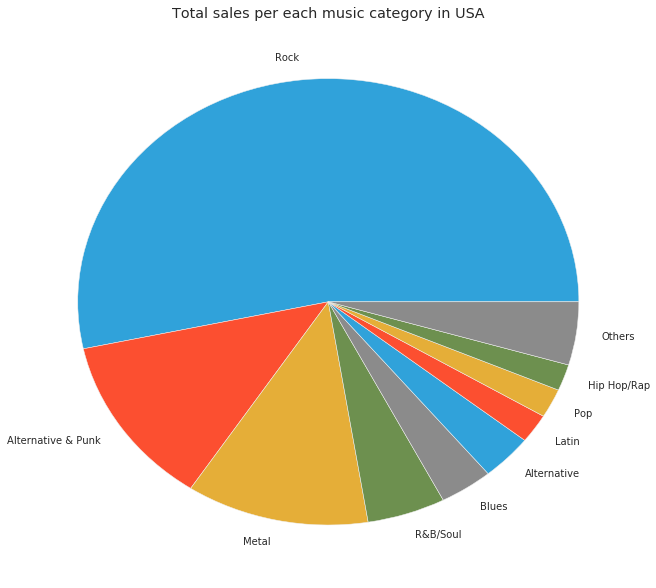

In [7]:
cat_sales.plot.pie(figsize= (10,10))
plt.ylabel('')
plt.title('Total sales per each music category in USA')
plt.show()


Based on the sales of tracks across different genres in the USA, we should purchase the new albums by the following artists:

* Red Tone (Punk)
* Slim Jim Bites (Blues)
* Meteor and the Girls (Pop)

It's worth keeping in mind that combined, these three genres only make up only 17% of total sales, so we should be on the lookout for artists and albums from the 'rock' genre, which accounts for 53% of sales.

## Analyzing Employee Sales Performance

Our database contains `employee` table. Let's check this table to find employee who made the best sales.

In [8]:
%%sql
SELECT e.first_name || ' ' || e.last_name AS name,
      e.title,
      e.hire_date,
      SUM(i.total) AS total_sale
 FROM customer c
INNER JOIN invoice i ON i.customer_id = c.customer_id
INNER JOIN employee e ON e.employee_id = c.support_rep_id
GROUP BY e.employee_id;

Done.


name,title,hire_date,total_sale
Jane Peacock,Sales Support Agent,2017-04-01 00:00:00,1731.5100000000039
Margaret Park,Sales Support Agent,2017-05-03 00:00:00,1584.0000000000034
Steve Johnson,Sales Support Agent,2017-10-17 00:00:00,1393.920000000002


In [9]:
query_employee_sales = """SELECT e.first_name || ' ' || e.last_name AS name,
      e.title,
      e.hire_date,
      SUM(i.total) AS total_sale
 FROM customer c
INNER JOIN invoice i ON i.customer_id = c.customer_id
INNER JOIN employee e ON e.employee_id = c.support_rep_id
GROUP BY e.employee_id;"""


# Connect to database
conn = sqlite3.connect('chinook.db')

# Read into dataframe
employee_sales = pd.read_sql_query(query_employee_sales, conn)

#set index on name
employee_sales = employee_sales.set_index('name')
employee_sales = employee_sales['total_sale']

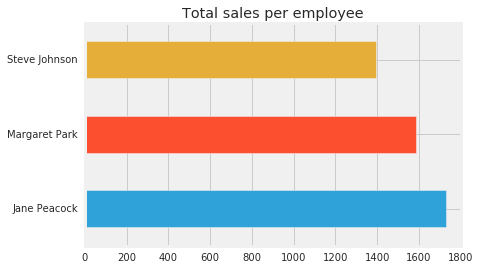

In [10]:
employee_sales.plot.barh()
plt.ylabel('')
plt.title('Total sales per employee')
plt.show()

We see that Jane Peacook made the best result in total sale (around 1700). However the differences are not huge. Steve Johnson who made the worst result (1400), the difference is only 300. Morover, if we look above on table and check `hire-date` column we can see that there is a pattern with experience of each employee and the sale result. These 2 variable are positive correlated, the bigger experience, the better sale result is.

## Analyzing Sales by Country

Our next task is to analyze sales data for customers from each different country.

Because there are a number of countries with only one customer, we'll group these customers as "Other" in analysis. We will do it during typing the query now.

In [11]:
%%sql
WITH country_sales AS
     (SELECT country,
             SUM(i.total) sum_sales,
             COUNT(DISTINCT (c.customer_id)) customers,
             SUM(i.total) / COUNT(DISTINCT (c.customer_id)) avg_sales
      FROM customer c
      INNER JOIN invoice i ON i.customer_id = c.customer_id
      GROUP BY 1
      ),
    country_one AS
    (SELECT country,
            sum_sales,
            customers,
            avg_sales
     FROM country_sales
     WHERE customers = 1
    ),
    country_one_all AS
    (SELECT 'Other',
       SUM(sum_sales) sum_sales,
       SUM(customers),
       SUM(sum_sales) / SUM(customers)
    FROM country_one),
    country_other_than_one AS
    (SELECT *
     FROM country_sales
     WHERE customers <> 1),
    combined AS
    (SELECT * FROM country_other_than_one
     UNION
     SELECT * FROM country_one_all)
   
    
SELECT *
FROM combined
ORDER BY (CASE
             WHEN customers = 15 THEN 1
             ELSE 0
           END), customers DESC;  
          


Done.


country,sum_sales,customers,avg_sales
USA,1040.4899999999998,13,80.0376923076923
Canada,535.5900000000001,8,66.94875000000002
Brazil,427.68000000000006,5,85.53600000000002
France,389.0699999999999,5,77.81399999999998
Germany,334.62,4,83.655
United Kingdom,245.52,3,81.84
Czech Republic,273.24000000000007,2,136.62000000000003
India,183.14999999999998,2,91.57499999999999
Portugal,185.13000000000002,2,92.56500000000001
Other,1094.9399999999998,15,72.996


In [12]:
query_country_sales = """
WITH country_sales AS
     (SELECT country,
             SUM(i.total) sum_sales,
             COUNT(DISTINCT (c.customer_id)) customers,
             SUM(i.total) / COUNT(DISTINCT (c.customer_id)) avg_sales
      FROM customer c
      INNER JOIN invoice i ON i.customer_id = c.customer_id
      GROUP BY 1
      ),
    country_one AS
    (SELECT country,
            sum_sales,
            customers,
            avg_sales
     FROM country_sales
     WHERE customers = 1
    ),
    country_one_all AS
    (SELECT 'Other',
       SUM(sum_sales) sum_sales,
       SUM(customers),
       SUM(sum_sales) / SUM(customers)
    FROM country_one),
    country_other_than_one AS
    (SELECT *
     FROM country_sales
     WHERE customers <> 1),
    combined AS
    (SELECT * FROM country_other_than_one
     UNION
     SELECT * FROM country_one_all)
   
    
SELECT *
FROM combined
ORDER BY (CASE
             WHEN customers = 15 THEN 1
             ELSE 0
           END), customers DESC;""" 
          

# Connect to database
conn = sqlite3.connect('chinook.db')

# Read into dataframe
country_sales = pd.read_sql_query(query_country_sales, conn)
country_sales = country_sales.set_index('country')
country_sales

,sum_sales,customers,avg_sales
country,,,
USA,1040.49,13,80.037692
Canada,535.59,8,66.948750
Brazil,427.68,5,85.536000
France,389.07,5,77.814000
Germany,334.62,4,83.655000
United Kingdom,245.52,3,81.840000
Czech Republic,273.24,2,136.620000
India,183.15,2,91.575000
Portugal,185.13,2,92.565000


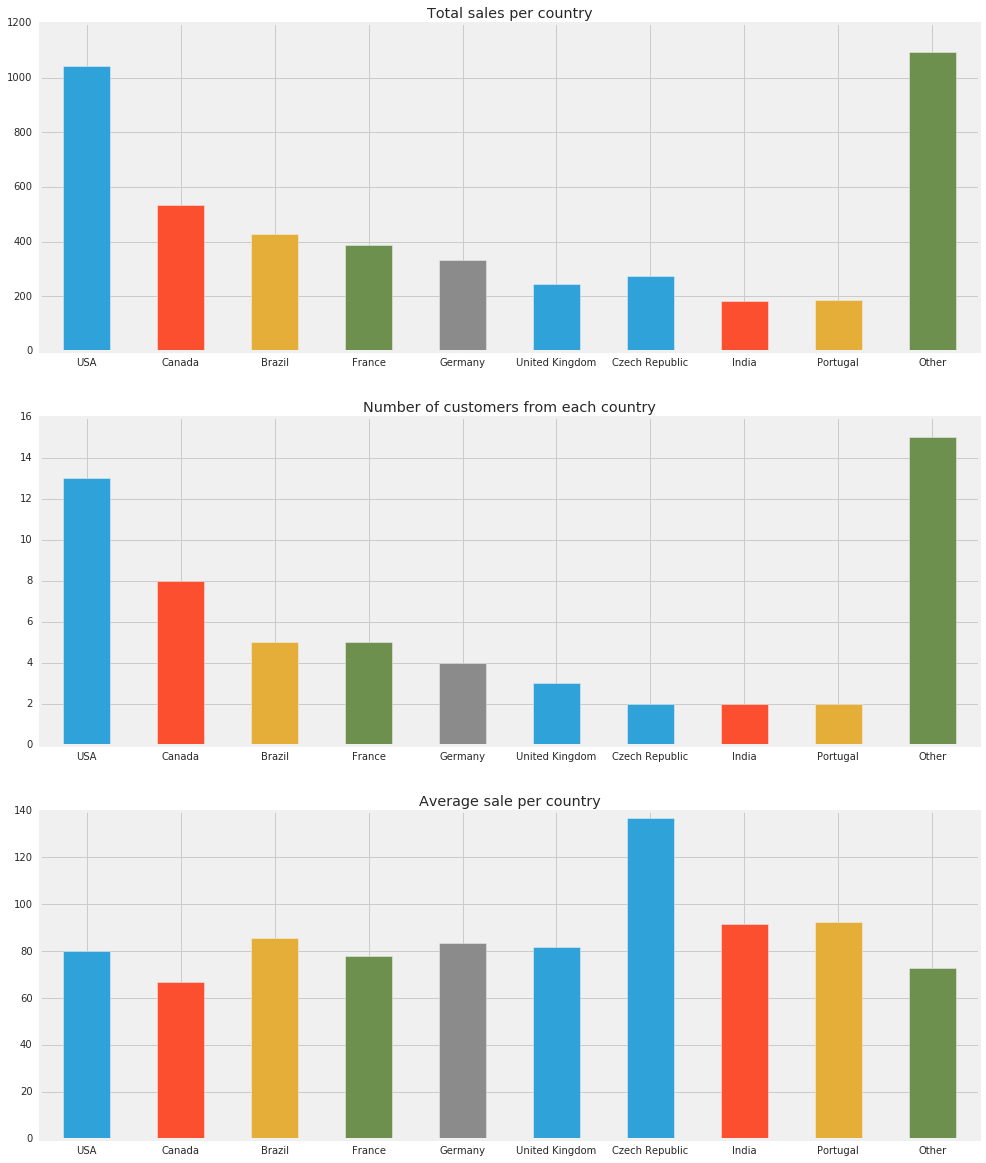

In [13]:
plt.figure(figsize=(15,20))
plt.subplot(3,1,1)
country_sales['sum_sales'].plot.bar(rot=0)
plt.xlabel('')
plt.title('Total sales per country')

plt.subplot(3,1,2)
country_sales['customers'].plot.bar(rot=0)
plt.xlabel('')
plt.title('Number of customers from each country')

plt.subplot(3,1,3)
country_sales['avg_sales'].plot.bar(rot=0)
plt.xlabel('')
plt.title('Average sale per country')

plt.show()

Looking at plots above we see that:

* **USA and Others country have the highest total sales**

However we have to remember that `Others` is some countries which there is only 1 customer, so the result - sum of whole countires could be insignificant.

* **The most customers come frome USA and other countires**

It seems obvious, because many these countires have the biggest total sales. 

* ** Czech Republic has the highest purchase average**

Purchase average in Czech Repubilc is almost 140. However, we can also see there are only 2 cusotmers form that country.

## Conclusions

So far, we analyzed the Chinook Records Store Database using SQL. We also used Pandas to convert our queries from SQL to Dataframes. It allowed us made some plots and our analyzing was easier.

Below are some conclusions which we observed:

* Rock, Punk and Metal are the most popular music category in the USA,
* More than 50% sales in USA are rock tracks,
* Jane Peacock	who is Sales Support Agent made the best sale result (around 1700),
* USA and Others country have the highest total sales,
* The most customers come frome USA and other countires,
* Czech Republic has the highest purchase average.